In [1]:
import pandas as pd
from catboost import CatBoostRegressor, Pool
import lightgbm as lgb
import dominance_analysis
import xgboost
import shap
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

shap.initjs()

all_runs = pd.read_csv('../logs-summary.csv')

# Rajoute des informations extraites du nom des runs.
def parse_filename(filename):
    if filename.strip().startswith('/home/local/mickus/talking-lizards/'):
        filename = filename.strip()[len('/home/local/mickus/talking-lizards/'):]
    components = filename.split('/')
    run_dir, exp_set, *setup, run_no, date, zero, events_fname = components

    setup = ' '.join(setup[::-1])
    
    return {
        'run no': int(run_no),
        'setup': setup,
        'difficulty strategy': (exp_set == 'exp1.5'),
    }

parsed_filenames = all_runs['event_file'].apply(parse_filename)
all_runs['run no'] = parsed_filenames.apply(lambda d: d['run no'])
all_runs['setup'] = parsed_filenames.apply(lambda d: d['setup'])
all_runs['difficulty strategy'] = parsed_filenames.apply(lambda d: d['difficulty strategy'])

# Filtrage des runs ; on cherche à ne garder que ceux ayant appris.
threshold = (60 / 100)
successful_runs = all_runs[all_runs['eval/success_rate from 0 (max)'] >= threshold]
successful_runs

/usr/lib/python3/dist-packages/dask/dataframe/utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/lib/python3/dist-packages/dask/dataframe/utils.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/usr/lib/python3/dist-packages/dask/dataframe/utils.py:362: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/usr/lib/python3/dist-packages/dask/dataframe/utils.py:362: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _

Loading BokehJS ...

,event_file,eval/scrambling-resistance from 0 (min),eval/scrambling-resistance from 0 (max),eval/scrambling-resistance from 0 (mean),eval/scrambling-resistance from 0 (median),eval/scrambling-resistance from 0 (std),eval/scrambling-resistance from 50 (min),eval/scrambling-resistance from 50 (max),eval/scrambling-resistance from 50 (mean),eval/scrambling-resistance from 50 (median),...,ALT eval/accuracy-eval-d from 50 (median),ALT eval/accuracy-eval-d from 50 (std),ALT eval/accuracy-eval-d from 75 (min),ALT eval/accuracy-eval-d from 75 (max),ALT eval/accuracy-eval-d from 75 (mean),ALT eval/accuracy-eval-d from 75 (median),ALT eval/accuracy-eval-d from 75 (std),run no,setup,difficulty strategy
0,/home/local/mickus/talking-lizards/runs/exp1.5...,0.856353,0.999999,0.907405,0.908304,0.024967,0.865993,0.944452,0.904660,0.903158,...,2.539200,0.049377,2.472007,2.637778,2.535166,2.529143,0.039874,10,frozen category-wise,True
1,/home/local/mickus/talking-lizards/runs/exp1.5...,0.897155,1.000000,0.929516,0.929958,0.016241,0.897155,0.950009,0.918644,0.915864,...,3.451670,0.185064,3.361049,3.640171,3.509509,3.520828,0.081161,4,frozen category-wise,True
2,/home/local/mickus/talking-lizards/runs/exp1.5...,0.901639,0.992834,0.932689,0.931172,0.015970,0.907729,0.963201,0.931508,0.929719,...,2.269952,0.100146,2.193559,2.752751,2.309608,2.262821,0.128170,1,frozen category-wise,True
3,/home/local/mickus/talking-lizards/runs/exp1.5...,0.832702,0.999996,0.867598,0.859324,0.030809,0.833781,0.865802,0.854998,0.855646,...,3.024468,0.166977,2.929886,3.314920,3.166275,3.171549,0.086196,6,frozen category-wise,True
4,/home/local/mickus/talking-lizards/runs/exp1.5...,0.846768,1.000000,0.881252,0.877687,0.022584,0.862032,0.899766,0.881393,0.880999,...,2.836800,0.072585,2.739026,2.968593,2.829678,2.830494,0.051679,3,frozen category-wise,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1115,/home/local/mickus/talking-lizards/runs/exp1/B...,0.871912,1.000000,0.901845,0.890420,0.032566,0.871912,0.898555,0.886576,0.886794,...,3.299503,0.075700,3.171856,3.429240,3.299141,3.294847,0.073977,9,B,False
1116,/home/local/mickus/talking-lizards/runs/exp1/B...,0.861081,1.000000,0.901393,0.890280,0.028898,0.862834,0.907135,0.886317,0.886840,...,2.763121,0.061626,2.711668,2.851962,2.775635,2.772767,0.040998,2,B,False
1117,/home/local/mickus/talking-lizards/runs/exp1/B...,0.856809,1.000000,0.912754,0.897344,0.042443,0.856809,0.923779,0.893047,0.894430,...,2.720347,0.045852,2.663161,2.826508,2.732511,2.725855,0.046575,5,B,False
1118,/home/local/mickus/talking-lizards/runs/exp1/B...,0.824167,1.000000,0.883080,0.876616,0.031633,0.859937,0.897938,0.880234,0.881425,...,3.116372,0.078874,2.884301,3.260122,3.118295,3.132357,0.079129,8,B,False


In [2]:
# les stats par groupe peuvent aussi se calculer directement sur l'objet `groupBy`
keys = [
    'eval/success_rate from 0 (max)', 
    'eval/scrambling-resistance from 75 (max)', 
    'FM_corr/Jaccard-based comp from 75 (max)', 
    'FM_corr/Normalised Lev-based comp from 75 (max)', 
    'ALT eval/success_rate from 0 (max)'
]
indices = ['setup', 'difficulty strategy']
means = successful_runs[[*indices, *keys]].groupby(by=indices).mean()
stds = successful_runs[[*indices, *keys]].groupby(by=indices).std()
experiments = pd.DataFrame({
  'convergence': (successful_runs[indices].groupby(by=indices).size() / all_runs[indices].groupby(by=indices).size()),
  **{f'[mean] {key}': means[key] for key in keys},
  **{f'[std] {key}': stds[key] for key in keys},
}).reset_index()
experiments['convergence'].fillna(0.0, inplace=True)

#experiments.insert(4, f"[mean; alt-space] {keys[0]}", experiments[f"[mean] {keys[0]}"].apply(lambda x: -np.log(1.0 - x))) # Ici on transforme la mean, alors que la mean de la transformée serait peut-être plus appropriée.

experiments

,setup,difficulty strategy,convergence,[mean] eval/success_rate from 0 (max),[mean] eval/scrambling-resistance from 75 (max),[mean] FM_corr/Jaccard-based comp from 75 (max),[mean] FM_corr/Normalised Lev-based comp from 75 (max),[mean] ALT eval/success_rate from 0 (max),[std] eval/success_rate from 0 (max),[std] eval/scrambling-resistance from 75 (max),[std] FM_corr/Jaccard-based comp from 75 (max),[std] FM_corr/Normalised Lev-based comp from 75 (max),[std] ALT eval/success_rate from 0 (max)
0,B,False,1.0,0.960278,0.906500,0.395623,0.346797,3.273785,0.013276,0.014396,0.107419,0.123228,0.322232
1,B,True,1.0,0.982019,0.917719,0.414249,0.346527,4.035442,0.003466,0.030257,0.085893,0.091866,0.195167
2,E,False,0.8,0.940826,0.907181,0.431183,0.399332,2.851593,0.014853,0.026800,0.097519,0.108912,0.229373
3,E,True,0.7,0.967721,0.919497,0.379237,0.341958,3.473513,0.009877,0.044762,0.089714,0.100198,0.306782
4,E+B,False,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,thawed feature-wise+E+H+B,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
108,thawed feature-wise+H,False,1.0,0.944153,0.908596,0.452509,0.414495,2.915345,0.013657,0.028790,0.076754,0.093956,0.269729
109,thawed feature-wise+H,True,1.0,0.969238,0.920376,0.346953,0.300133,3.604284,0.015082,0.010491,0.063564,0.071837,0.535349
110,thawed feature-wise+H+B,False,1.0,0.961487,0.924362,0.439426,0.408594,3.326976,0.014550,0.016306,0.054386,0.067175,0.404392


In [3]:
def infer_setup_runwise_success(row):

    def lookup(keyword):
        return int(keyword in row['setup'])

    cvg = experiments[(experiments['setup'] == row['setup'])  & (experiments['difficulty strategy'] == row['difficulty strategy'])].convergence.to_list()
    assert len(cvg) == 1, cvg
    cvg = cvg[0]
    
    record = {
        'DV': row['ALT eval/success_rate from 0 (max)'],
        'S': int(row['difficulty strategy']),
        'F': lookup('frozen'),
        'CW': lookup('category-wise'),
        'FW': lookup('feature-wise'),
        'AE': lookup('auto-encoder'),
        'E': lookup('E'),
        'H': lookup('H'),
        'B': lookup('B'),
        'cvg': cvg
    }

    return record


def infer_setup_expwise_success(row):

    def lookup(keyword):
        return int(keyword in row['setup'])

    cvg = experiments[(experiments['setup'] == row['setup'])  & (experiments['difficulty strategy'] == row['difficulty strategy'])].convergence.to_list()
    assert len(cvg) == 1, cvg
    cvg = cvg[0]
    
    record = {
        'DV': row['[mean] ALT eval/success_rate from 0 (max)'],
        'S': int(row['difficulty strategy']),
        'F': lookup('frozen'),
        'CW': lookup('category-wise'),
        'FW': lookup('feature-wise'),
        'AE': lookup('auto-encoder'),
        'E': lookup('E'),
        'H': lookup('H'),
        'B': lookup('B'),
        'cvg': cvg
    }

    return record


def infer_setup_runwise_lev(row):

    def lookup(keyword):
        return int(keyword in row['setup'])

    cvg = experiments[(experiments['setup'] == row['setup'])  & (experiments['difficulty strategy'] == row['difficulty strategy'])].convergence.to_list()
    assert len(cvg) == 1, cvg
    cvg = cvg[0]
    
    record = {
        'DV': row['FM_corr/Normalised Lev-based comp from 75 (max)'],
        'S': int(row['difficulty strategy']),
        'F': lookup('frozen'),
        'CW': lookup('category-wise'),
        'FW': lookup('feature-wise'),
        'AE': lookup('auto-encoder'),
        'E': lookup('E'),
        'H': lookup('H'),
        'B': lookup('B'),
        'cvg': cvg
    }

    return record


def infer_setup_expwise_lev(row):

    def lookup(keyword):
        return int(keyword in row['setup'])

    cvg = experiments[(experiments['setup'] == row['setup'])  & (experiments['difficulty strategy'] == row['difficulty strategy'])].convergence.to_list()
    assert len(cvg) == 1, cvg
    cvg = cvg[0]
    
    record = {
        'DV': row['[mean] FM_corr/Normalised Lev-based comp from 75 (max)'],
        'S': int(row['difficulty strategy']),
        'F': lookup('frozen'),
        'CW': lookup('category-wise'),
        'FW': lookup('feature-wise'),
        'AE': lookup('auto-encoder'),
        'E': lookup('E'),
        'H': lookup('H'),
        'B': lookup('B'),
        'cvg': cvg
    }

    return record

In [4]:
runs_lev = pd.DataFrame.from_records(successful_runs.apply(infer_setup_runwise_lev, axis=1))
runs_suc = pd.DataFrame.from_records(successful_runs.apply(infer_setup_runwise_success, axis=1))

converged_exps = experiments[experiments.convergence > 0.0]
exps_lev = pd.DataFrame.from_records(converged_exps.apply(infer_setup_expwise_lev, axis=1))
exps_suc = pd.DataFrame.from_records(converged_exps.apply(infer_setup_expwise_success, axis=1))

In [5]:
# tested for runs_lev and runs_suc only
y_suc = runs_suc.DV
X_suc = runs_suc.drop('DV', axis=1)

In [6]:
sample_ind=10

model = CatBoostRegressor(iterations=300, learning_rate=0.1, random_seed=123)
cat_features = list(range(0, X_suc.shape[1] - 1))
model.fit(X_suc, y_suc, cat_features=cat_features, verbose=False, plot=False)
model.set_feature_names(X_suc.columns)

explainer = shap.TreeExplainer(model, feature_names=X_suc.columns)
shap_suc_values_ = explainer.shap_values(Pool(X_suc, y_suc, cat_features=cat_features))

In [7]:
model.get_feature_importance(data=Pool(X_suc, y_suc, cat_features=cat_features))  

array([34.61916397, 30.77844488,  4.09729211,  2.4853763 ,  2.57788081,
        3.32142982, 10.36683492, 10.2137908 ,  1.53978639])

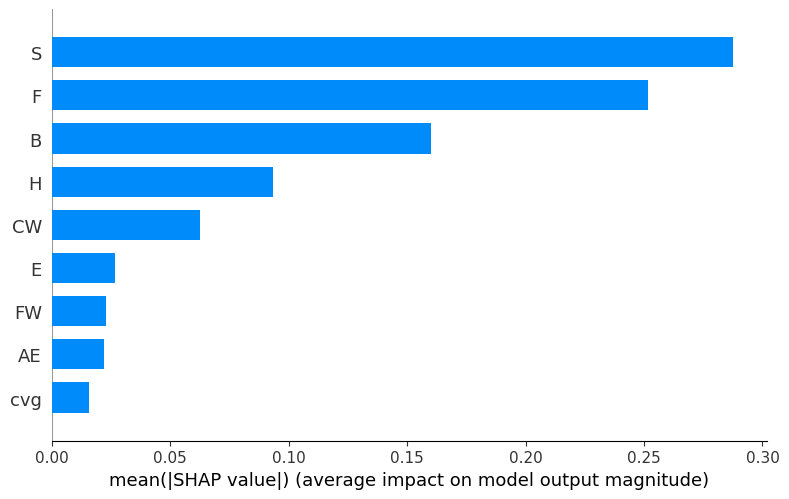

In [8]:
shap.summary_plot(shap_suc_values_, plot_type='bar', feature_names=X_suc.columns)

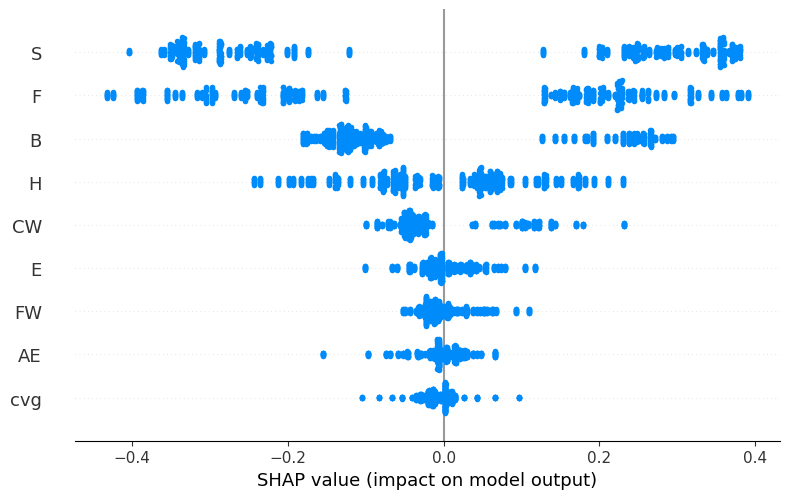

In [9]:
shap.summary_plot(shap_suc_values_, feature_names=X_suc.columns) 

Exact explainer: 806it [00:39, 18.39it/s]                                       


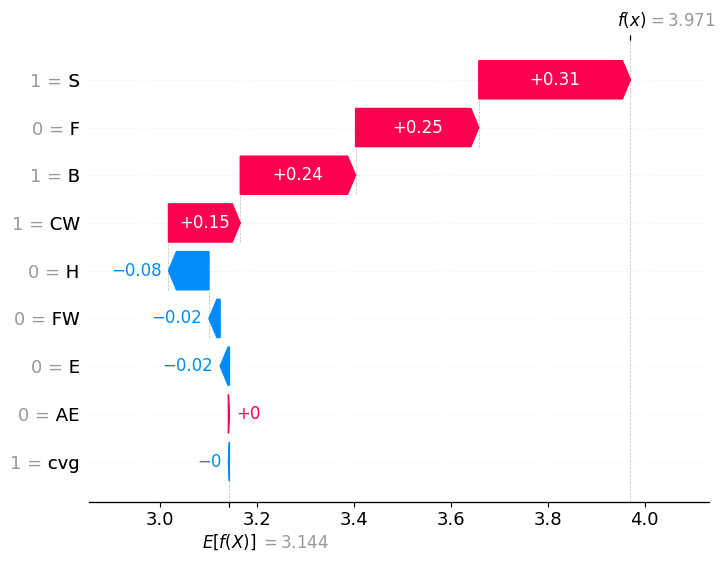

In [10]:
model = xgboost.XGBRegressor(max_depth=1).fit(X_suc, y_suc)
explainer = shap.Explainer(model.predict, X_suc)
shap_suc_values = explainer(X_suc)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_suc_values[y_suc.argmax()])

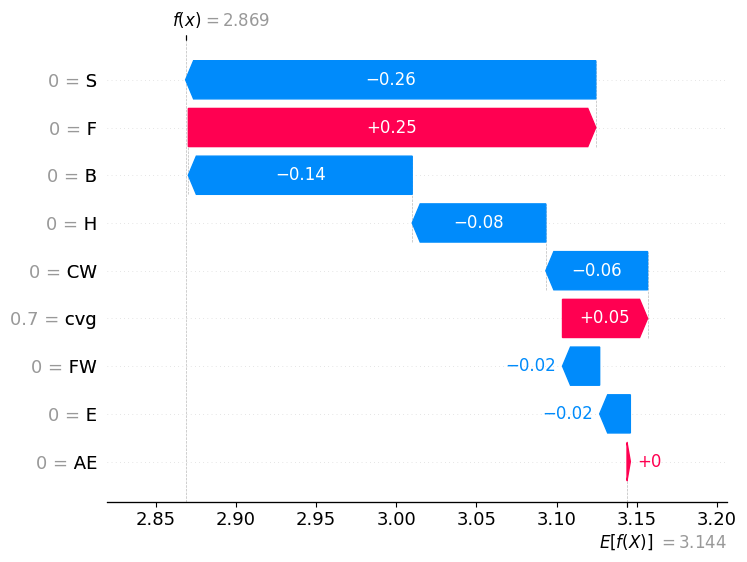

In [11]:
base_run = X_suc[(
    (X_suc.F==0) 
    & (X_suc.S==0) 
    & (X_suc.B==0) 
    & (X_suc.AE==0) 
    & (X_suc.H==0) 
    & (X_suc.FW==0) 
    & (X_suc.E==0) 
    & (X_suc.CW==0)
)].index[0]
shap.plots.waterfall(shap_suc_values[base_run])

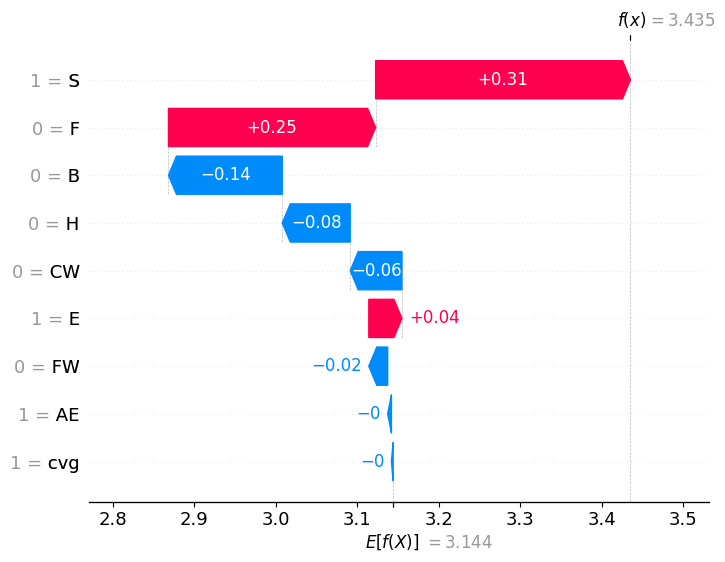

In [12]:
random_difficulty_strat_run = X_suc[X_suc.S==1].sample(n=1).index[0]
shap.plots.waterfall(shap_suc_values[random_difficulty_strat_run])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


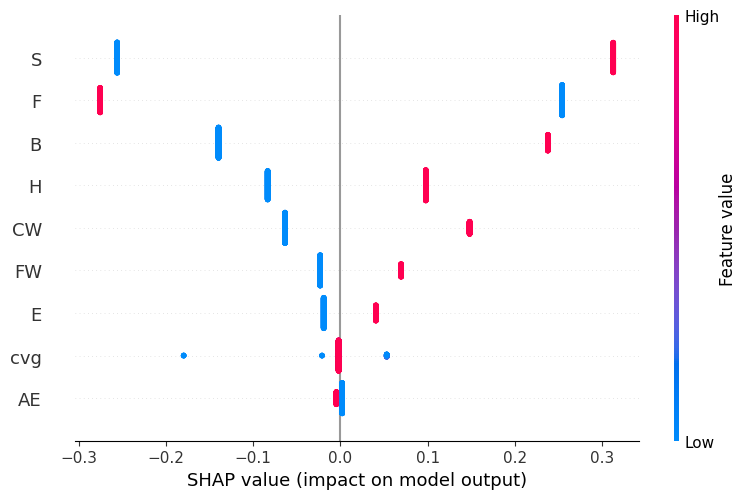

In [13]:
shap.summary_plot(shap_suc_values)

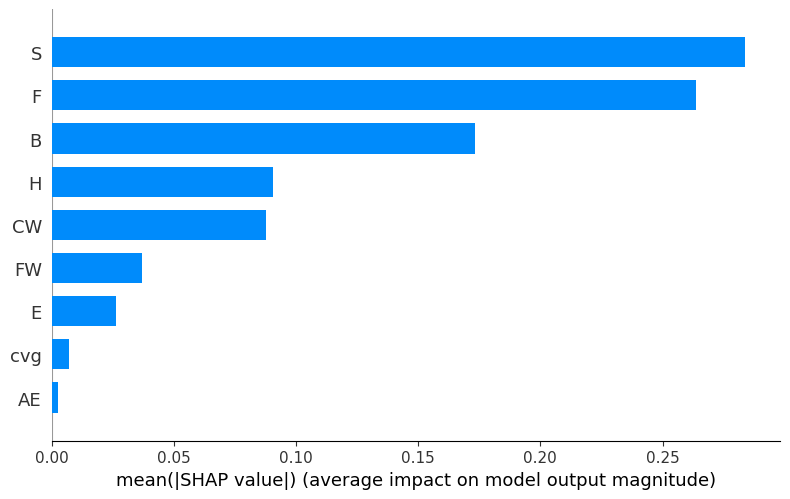

In [14]:
shap.summary_plot(shap_suc_values, plot_type='bar')

In [15]:
shap_suc_df = pd.DataFrame(
    np.concatenate([shap_suc_values.values, X_suc], axis=1),
    columns=[f'{col}_shap_suc' for col in X_suc.columns] + X_suc.columns.to_list()
)
for col in ['S', 'F', 'AE', 'CW', 'FW', 'E', 'B', 'H']:
    shap_suc_df[col] = shap_suc_df[col].apply(int)

In [16]:
y_lev = runs_lev.DV
X_lev = runs_lev.drop('DV', axis=1)

Exact explainer: 806it [00:25, 17.21it/s]                                       


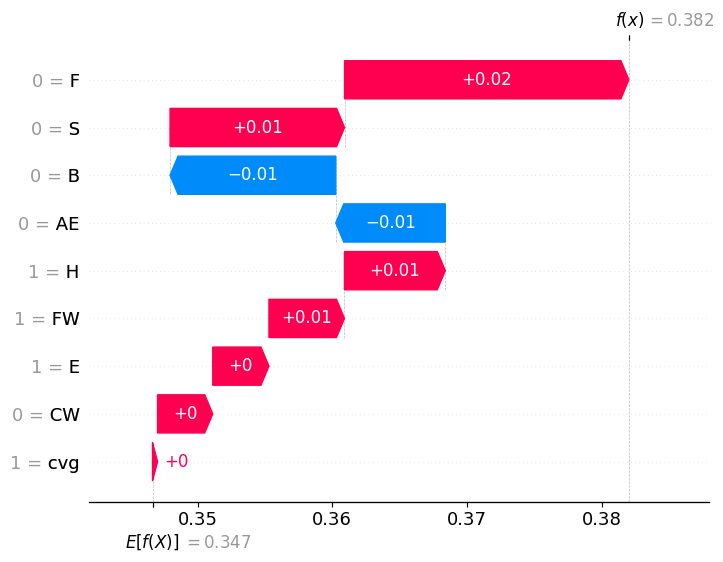

In [17]:
model = xgboost.XGBRegressor(max_depth=1).fit(X_lev, y_lev)
explainer = shap.Explainer(model.predict, X_lev)
shap_lev_values = explainer(X_lev)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_lev_values[y_lev.argmax()])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


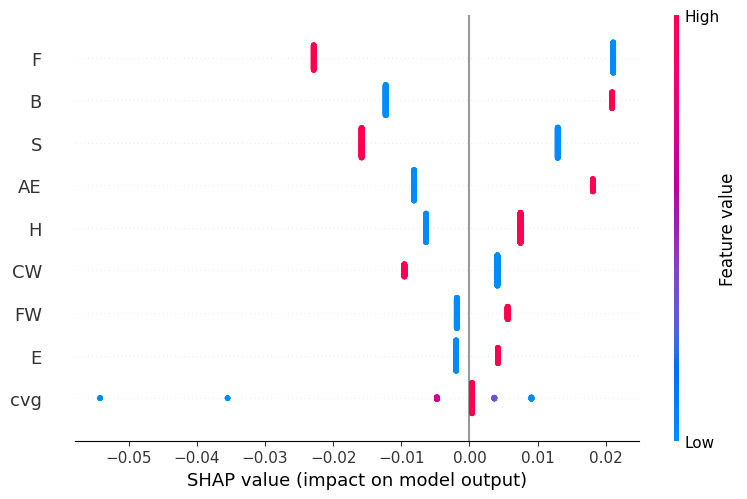

In [18]:
shap.summary_plot(shap_lev_values)

In [19]:
shap_lev_df = pd.DataFrame(
    np.concatenate([shap_lev_values.values, X_lev], axis=1),
    columns=[f'{col}_shap_lev' for col in X_lev.columns] + X_suc.columns.to_list()
)

    
shap_all_df =  pd.DataFrame(
    np.concatenate([shap_lev_values.values, shap_suc_values.values, X_lev], axis=1),
    columns=(
        [f'{col}_shap_lev' for col in X_lev.columns] 
        + [f'{col}_shap_suc' for col in X_suc.columns] 
        + X_suc.columns.to_list()
    )
)


for col in ['S', 'F', 'AE', 'CW', 'FW', 'E', 'B', 'H']:
    shap_lev_df[col] = shap_lev_df[col].apply(int)
    shap_all_df[col] = shap_all_df[col].apply(int)

shap_all_df

,S_shap_lev,F_shap_lev,CW_shap_lev,FW_shap_lev,AE_shap_lev,E_shap_lev,H_shap_lev,B_shap_lev,cvg_shap_lev,S_shap_suc,...,cvg_shap_suc,S,F,CW,FW,AE,E,H,B,cvg
0,-0.015835,-0.022869,-0.009562,-0.001869,-0.008134,-0.001964,-0.006378,-0.012302,0.000374,0.312598,...,-0.002013,1,1,1,0,0,0,0,0,1.0
1,-0.015835,-0.022869,-0.009562,-0.001869,-0.008134,-0.001964,-0.006378,-0.012302,0.000374,0.312598,...,-0.002013,1,1,1,0,0,0,0,0,1.0
2,-0.015835,-0.022869,-0.009562,-0.001869,-0.008134,-0.001964,-0.006378,-0.012302,0.000374,0.312598,...,-0.002013,1,1,1,0,0,0,0,0,1.0
3,-0.015835,-0.022869,-0.009562,-0.001869,-0.008134,-0.001964,-0.006378,-0.012302,0.000374,0.312598,...,-0.002013,1,1,1,0,0,0,0,0,1.0
4,-0.015835,-0.022869,-0.009562,-0.001869,-0.008134,-0.001964,-0.006378,-0.012302,0.000374,0.312598,...,-0.002013,1,1,1,0,0,0,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
800,0.012956,0.021110,0.004098,-0.001869,-0.008134,-0.001964,-0.006378,0.020947,0.000374,-0.255762,...,-0.002013,0,0,0,0,0,0,0,1,1.0
801,0.012956,0.021110,0.004098,-0.001869,-0.008134,-0.001964,-0.006378,0.020947,0.000374,-0.255762,...,-0.002013,0,0,0,0,0,0,0,1,1.0
802,0.012956,0.021110,0.004098,-0.001869,-0.008134,-0.001964,-0.006378,0.020947,0.000374,-0.255762,...,-0.002013,0,0,0,0,0,0,0,1,1.0
803,0.012956,0.021110,0.004098,-0.001869,-0.008134,-0.001964,-0.006378,0.020947,0.000374,-0.255762,...,-0.002013,0,0,0,0,0,0,0,1,1.0


In [20]:
points = []

for col in ['S', 'F', 'AE', 'CW', 'FW', 'E', 'B', 'H']:
    for val, sub_df in shap_all_df[[col, f'{col}_shap_lev', f'{col}_shap_suc']].groupby(by=col):
        print(
            col, 
            val, 
            sub_df[f'{col}_shap_lev'].max() - sub_df[f'{col}_shap_lev'].min(), 
            sub_df[f'{col}_shap_suc'].max() - sub_df[f'{col}_shap_suc'].min(),
        )
        points.append([f'{col}={val}', sub_df[f'{col}_shap_lev'].mean(), sub_df[f'{col}_shap_suc'].mean()])

S 0 7.75925185214632e-10 1.246588580139374e-07
S 1 1.4723823549278592e-10 1.4385722851839589e-07
F 0 8.047691624213371e-09 1.419669116708988e-07
F 1 6.705536126361267e-11 1.389469411194888e-07
AE 0 6.854534648215171e-10 1.1119956072613846e-07
AE 1 8.710083834739812e-10 6.871564010163533e-08
CW 0 8.089218357654193e-11 7.72362658135739e-08
CW 1 1.272984852945802e-09 1.7040116401245697e-07
FW 0 1.2595040158394633e-10 1.0873022583332559e-07
FW 1 6.705520166905288e-11 6.00587758692317e-08
E 0 5.190570790021554e-10 1.4984607712986708e-07
E 1 4.718701818173798e-11 6.71545665464901e-08
B 0 8.834260094292556e-10 1.924832659927489e-07
B 1 1.9868232059572222e-11 1.9708133899842828e-07
H 0 1.1041050981472345e-09 1.0256540200481723e-07
H 1 2.7318806938847473e-11 1.2692383358214876e-07


Text(0, 0.5, 'SHAP Success')

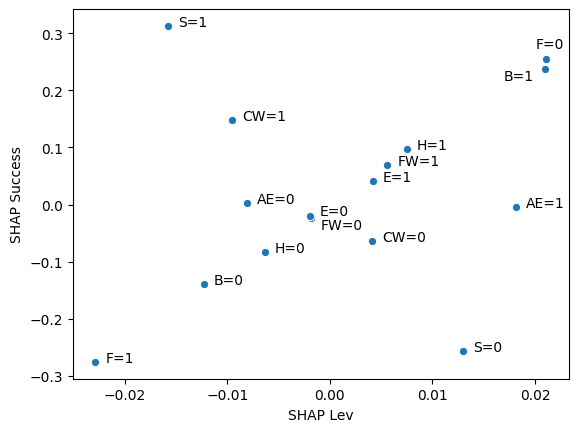

In [21]:
_, x, y = zip(*points)
sns.scatterplot(x=x, y=y)
ax = plt.gca()
for label, x, y in points:
    if label == 'FW=0':
        ax.text(x + 1e-3, y - 2e-2, label)
    elif label == 'B=1':
        ax.text(x - 4e-3, y - 2e-2, label)
    elif label == 'F=0':
        ax.text(x - 1e-3, y + 2e-2, label)
    else:
        ax.text(x + 1e-3, y, label)
    
# Set x-axis label
plt.xlabel('SHAP Lev')
# Set y-axis label
plt.ylabel('SHAP Success')

In [22]:
da = dominance_analysis.Dominance(data=runs_suc, target='DV', objective=1)
da.incremental_rsquare()

Selecting 9 Best Predictors for the Model
Selected Predictors :  ['S', 'F', 'CW', 'FW', 'AE', 'E', 'H', 'B', 'cvg']

********************  R-Squared of Complete Model :  ********************
R Squared : 0.5092692600228398

Selecting 9 Best Predictors for the Model
Selected Predictors :  ['S', 'F', 'CW', 'FW', 'AE', 'E', 'H', 'B', 'cvg']

Creating models for 511 possible combinations of 9 features :


100%|█████████████████████████████████████████████| 9/9 [00:04<00:00,  1.87it/s]


#########################  Model Training Done!!!!!  #########################

#########################  Calculating Variable Dominances  #########################


100%|█████████████████████████████████████████████| 8/8 [00:00<00:00, 65.41it/s]

#########################  Variable Dominance Calculation Done!!!!!  #########################



{'S': 0.21190712727331787,
 'F': 0.16610045250114472,
 'CW': 0.011540617666794642,
 'FW': 0.002686490408306621,
 'AE': 0.007928908550338233,
 'E': 0.00586581091025871,
 'H': 0.024123555449757875,
 'B': 0.07301789230229096,
 'cvg': 0.006098404960630176}

In [23]:
# note: had to mess a bit with the lib to remove a deprecated keyword
da.plot_incremental_rsquare()

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
